In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

01
02
03
04
05
06
07
08
09
10
11
12


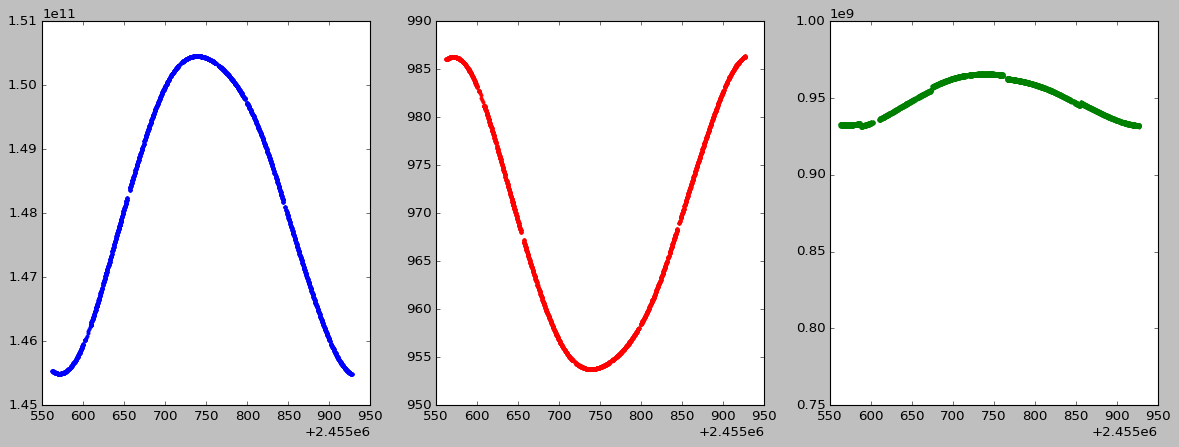

./EIT/2011/12/31/SOHO_EIT_304_20111231T131946_L1.fits
145485425245.0
./EIT/2011/01/26/SOHO_EIT_284_20110126T010639_L1.fits
931063177.4726714


In [4]:
#for year in range(1996, 2010):
for year in [2011]:
    solarDistances = []
    obsDates = []
    solarRads = []
    pixelScales = []
    fpaths = []
    physDistToEdge = []
    
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                
                solarDistances.append(header['DSUN_OBS'])
                obsDates.append(header['DATE-BEG'])
                solarRads.append(header['RSUN_OBS'])
                pixelScales.append(header['CDELT1'])
                fpaths.append(f.path)

                #find minimum physical distance from center of disk to any edge 
                xcenter, ycenter = eit.center_from_header(header)

                if "full_sun" in sci_obj_ and np.shape(data) == (1024,1024): 
                    #physical scale of each pixel in this image is:
                    thisPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * header['DSUN_OBS']
    
                    pixelsToNearestEdge = np.min(np.array((xcenter, 1024-xcenter, ycenter, 1024-ycenter)))
                    physToNearestEdge = pixelsToNearestEdge * thisPhysPixelScale
    
                    physDistToEdge.append(physToNearestEdge)

                else:
                    physDistToEdge.append(0)
    
    solarDistances = np.array(solarDistances)
    solarRads = np.array(solarRads)
    pixelScales = np.array(pixelScales)
    physDistToEdge = np.array(physDistToEdge)
    fpaths = np.array(fpaths)
    
    t = astropy.time.Time(obsDates, format='isot', scale='utc').jd
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    axes[0].plot(t[solarDistances>1.e11], solarDistances[solarDistances>1.e11],'b.')
    axes[1].plot(t[solarDistances>1.e11], solarRads[solarDistances>1.e11],'r.')
    axes[2].plot(t[solarDistances>1.e11], physDistToEdge[solarDistances>1.e11],'g.')
    axes[2].set_ylim(0.75e9,1.e9)
    plt.show()


    goodDistImgs = (solarDistances > 0.)
    print(fpaths[goodDistImgs][np.argmin(solarDistances[goodDistImgs])])
    print(solarDistances[goodDistImgs][np.argmin(solarDistances[goodDistImgs])])

    goodShapeImgs = (physDistToEdge > 0.)
    print(fpaths[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])])
    print(physDistToEdge[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])])
    

/Users/Emily/Documents/astro/archivalSOHO/data/EITfunc/EITfunc/EITlook.py:94: RuntimeWarning: invalid value encountered in log10
  cs = ax0.imshow(np.log10(data),cmap='Greys_r',interpolation='None',origin="lower")


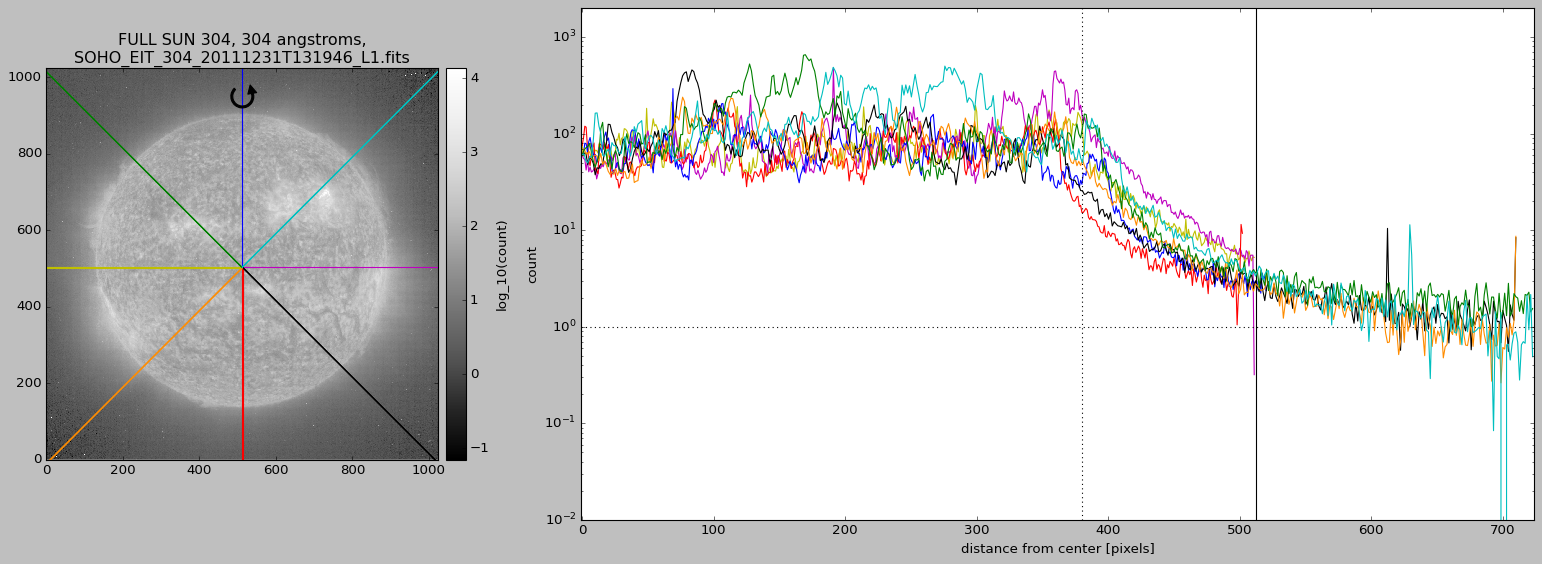

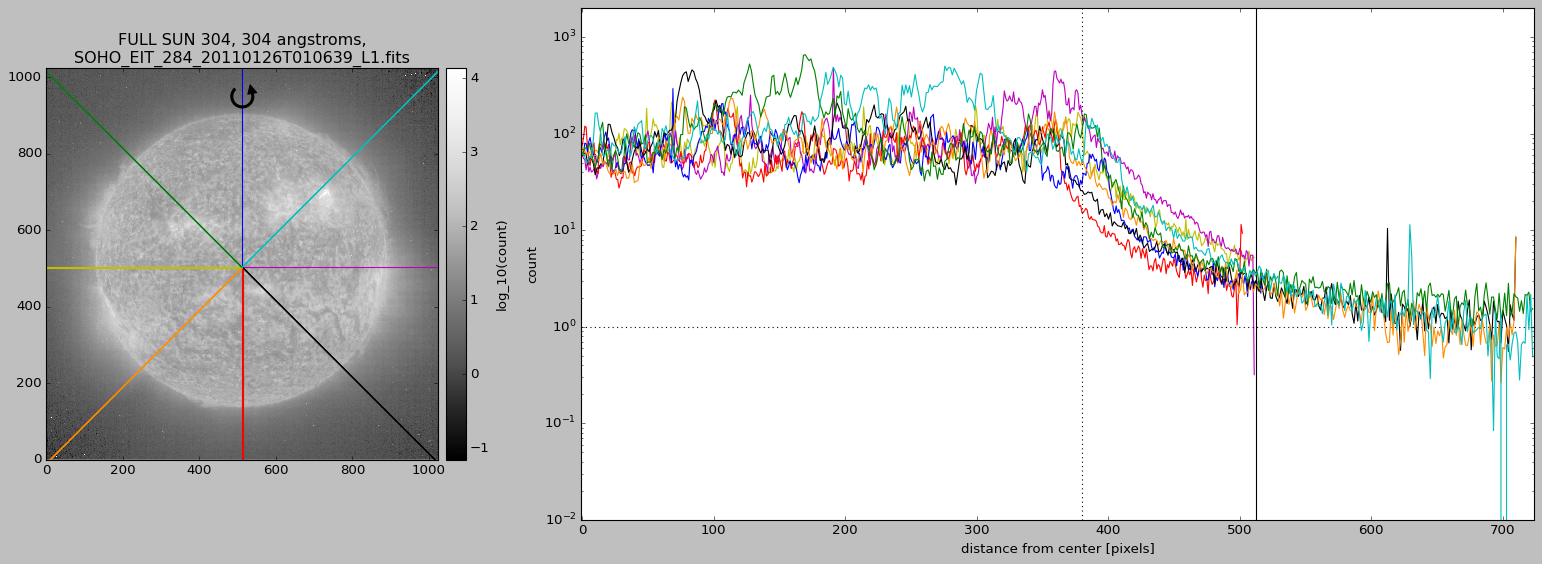

In [5]:
goodDistImgs = (solarDistances > 0.)
minDistanceFITS = fpaths[goodDistImgs][np.argmin(solarDistances[goodDistImgs])]
hdul = fits.open(minDistanceFITS)
header = hdul[0].header
data = hdul[0].data
xcenter, ycenter = eit.center_from_header(header)
xcenter = int(np.round(xcenter,0))
ycenter = int(np.round(ycenter,0))
eit.plot_full_sun_EIT(minDistanceFITS.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)

goodShapeImgs = (physDistToEdge > 0.)
minDistanceToEdgeFITS = fpaths[goodShapeImgs][np.argmin(physDistToEdge[goodShapeImgs])]
hdul = fits.open(minDistanceFITS)
header = hdul[0].header
data = hdul[0].data
xcenter, ycenter = eit.center_from_header(header)
xcenter = int(np.round(xcenter,0))
ycenter = int(np.round(ycenter,0))
eit.plot_full_sun_EIT(minDistanceToEdgeFITS.split("/")[-1], header, data, xcenter=xcenter, ycenter=ycenter)

#luckily this is a square image, so we'll be drawing a square box around images taken from farther away

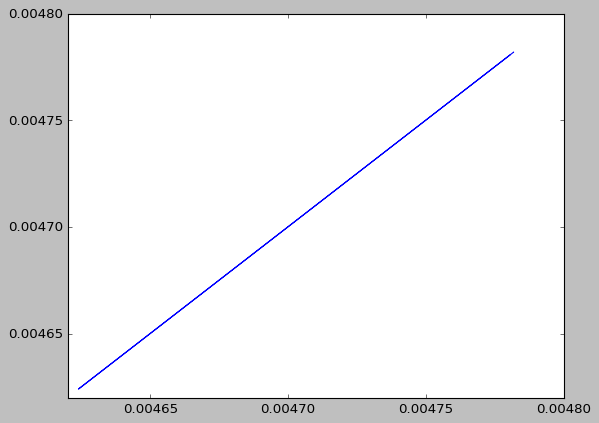

In [6]:
plt.plot(solarRads[solarDistances>1.e11] * np.pi/(3600*180.), 695699968/solarDistances[solarDistances>1.e11])

In [7]:
medianSolarDistance = np.median(solarDistances[solarDistances > 0.])
print(medianSolarDistance)
minSolarDistance = np.min(solarDistances[solarDistances > 0.])
print(minSolarDistance)

maxSolarRad = np.max(solarRads[solarDistances > 0.])
print(maxSolarRad)

minPhysDistToEdge = np.min(physDistToEdge[physDistToEdge > 0.])
print(minPhysDistToEdge)

148386413702.0
145485425245.0
986.334714263
931063177.4726714


In [14]:
darkImgData =np.loadtxt("./darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

(2487, 3)


In [26]:
#for year in range(1996, 2010):
for year in [1996]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    ts = []
    fs = []
    us = []
    ws = []

    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            print(d)
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()
                dSun = header['DSUN_OBS']
            
                #exclude pathological case where solar distance is 0
                if dSun < 1.e11:
                    continue

                #find center of solar disk
                xcenter, ycenter = eit.center_from_header(header) # pixels

                if "full_sun" in sci_obj_: 
                    hist = str(header['HISTORY'])

                    # catch the one image with sci_obj_ = 'full_sun_304' which
                    # doesn't have a wavelength keyword (it seems to be a mislabeled dark image?) 
                    if "Data not calibrated" in hist:
                        continue

                    #exclude lower-resolution or partial images and images with missing data blocks and camera errors
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0 and header['CAMERERR'] == 'no':
                        
                        t = astropy.time.Time(header['DATE-BEG'], format='isot', scale='utc').jd
                        
                        if t > darkImgData[0][0] and t < darkImgData[-1][0]:
                            dark = eit.interpolate_darkcurrent(t, darkImgData)
                        elif t < darkImgData[0][0]:
                            dark = darkImgData[0][1]
                        elif t > darkImgData[-1][0]:
                            dark = darkImgData[-1][1]

                        f, u = eit.image_to_LCpoint(data, darkFlux=dark, xcenter=xcenter, ycenter=ycenter, maskBrightSpots=True)
                        w = header['WAVELNTH']
                
                        ts.append(t)
                        fs.append(f*(medianSolarDistance/dSun))
                        us.append(u*(medianSolarDistance/dSun))
                        ws.append(w)
                        
                        
    ts = np.array(ts)
    fs = np.array(fs)
    us = np.array(us)
    ws = np.array(ws)

01
1
2
3
4
5
6
15
16
18
19
20
21
22
23
24
25
26
27
28
30
31
02
1
2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
03
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
04
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
05
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
30
31
06
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
07
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
08
1
2
3
4
5
6
7
8
9
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
09
1
2
3
4
5
6
9
10
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
10
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
11
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
12
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [27]:
print(np.shape(ts)) # =2877 in 1996, =2520 in 2011
print(np.shape(fs))
print(np.shape(us))
print(np.shape(ws))

(1491,)
(1491,)
(1491,)
(1491,)


In [28]:
m171 = (ws == 171)
m195 = (ws == 195)
m284 = (ws == 284)
m304 = (ws == 304)
wmasks = [m304,m284,m195,m171]

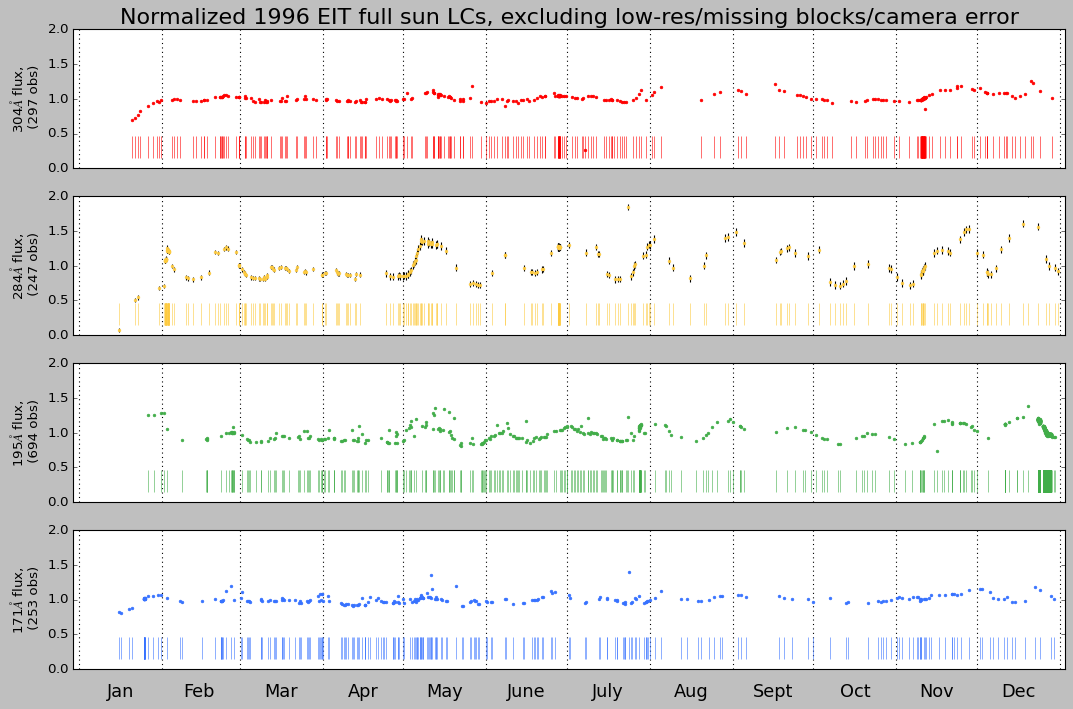

In [29]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,10))

runningdaycount = 0
for i, d in enumerate(dayspermonth):
    for ax in axes:
        ax.axvline(runningdaycount,color='k',ls=':')    
    axes[3].text(runningdaycount + d/2, -0.4, months[i],horizontalalignment='center',fontsize=16)
    runningdaycount = runningdaycount+d
    # leap years
    if year%4 == 0 and i==1:
        runningdaycount = runningdaycount + 1

for i, ax in enumerate(axes):
    wmask = wmasks[i]
    plotcolor = cs[i]
    axes[i].errorbar(ts[wmask] - jan1_thisyear, fs[wmask]/np.median(fs[wmask]), yerr=us[wmask]/np.median(fs[wmask]), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c=plotcolor,ecolor='k')
    axes[i].plot(ts[wmask] - jan1_thisyear, 0.3*np.ones_like(ts[wmask]), marker='|',ms=20,mec=plotcolor,ls='None')
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))

for ax in axes:
    ax.set_xticks([])
    ax.set_xlim(-2,runningdaycount+2)
    #ax.axhline(1,ls=":",color='k',zorder=1,lw=0.5)
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,2)

    
axes[0].set_title(r'Normalized {0} EIT full sun LCs, excluding low-res/missing blocks/camera error'.format(year),fontsize=20)
#plt.show()
plt.savefig("./EIT_LCs_{0}_nocameraerror.pdf".format(year), bbox_inches="tight")

# Old version (cutout annulus rather than whole image; didn't account for bright pixel areas)

In [46]:
#for year in range(1996, 2010):
for year in [2011]:
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(year)
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    obsTimes_171 = []
    obsTimes_195 = []
    obsTimes_284 = []
    obsTimes_304 = []
    obsTimes_dark = []

    fluxes_171 = []
    fluxes_195 = []
    fluxes_284 = []
    fluxes_304 = []
    medianfluxes_dark = []

    #flux that does not make it into the image cutout
    missing_fluxes_171 = []
    missing_fluxes_195 = []
    missing_fluxes_284 = []
    missing_fluxes_304 = []

    temps_171 = []
    temps_195 = []
    temps_284 = []
    temps_304 = []

    sci_objs = []
    dates = []
    fpaths = []
    for m in range(1,13):
        month = str(m).zfill(2)
        days = sorted([int(f.path[-2:]) for f in os.scandir("./EIT/{0}/{1}/".format(year,month)) if f.is_dir()])
        print(month)
        
        for d in days:
            day = str(d).zfill(2)
            fitsFiles = os.scandir("./EIT/{0}/{1}/{2}/".format(year,month,day))
            
            for f in fitsFiles:
                hdul = fits.open(f.path)
                header = hdul[0].header
                data = hdul[0].data
                
                sci_objs.append(header['SCI_OBJ'])
                dates.append(header['DATE-BEG'])
                fpaths.append(f.path)

                sci_obj_ = header['SCI_OBJ'].replace("/"," ").replace(" ","_").lower()

                #This is an extremely naive method of extracting the LC--just sum up all the flux in the image
                #and normalize by exposure time and solar distance
                    
                #pixel counts have units of DN/s already so they've already been normalized by exposure time
                #pixel count * exp time has units of DN

                #to weight by distance, want to trim the edges of all the images so that they have the same field of
                #view as the one taken closest to the Sun (where the Sun has angular radius maxSolarRad = 986.010427668arcsec)

                #exclude pathological case where solar distance is 0
                if header['DSUN_OBS'] < 1.e11:
                    continue


                #find center of solar disk
                xcenter, ycenter = eit.center_from_header(header) # pixels
                
                #minimum physical distance from center of disk to edge of image in 1996 is minPhysDistToEdge ~= 8.07e8 m

                #physical scale of each pixel in this image is:
                thisPhysPixelScale = 2.627 * (np.pi/(3600*180.)) * header['DSUN_OBS']  #meters/pixel

                # we want to trim our image into a circle of radius 8.07e8 m around (xcenter, ycenter)
                pixCutoutRadius = minPhysDistToEdge/thisPhysPixelScale # m /(m/pixel)
            
                image_idxs = np.indices((1024,1024))
                cutout_mask = ( ((image_idxs[0,:,:] - ycenter)**2 + (image_idxs[1,:,:] - xcenter)**2) <= (pixCutoutRadius)**2 )

                missing_mask = ( ((image_idxs[0,:,:] - ycenter)**2 + (image_idxs[1,:,:] - xcenter)**2) > (pixCutoutRadius)**2 )

                if "full_sun" in sci_obj_: 
                    hist = str(header['HISTORY'])

                    # catch the one image with sci_obj_ = 'full_sun_304' which
                    # doesn't have a wavelength keyword (it seems to be a mislabeled dark image?) 
                    if "Data not calibrated" in hist:
                        continue
                        
                    wavelength = header['WAVELNTH']

                    #exclude lower-resolution or partial images and images with missing data blocks
                    if np.shape(data) == (1024,1024) and header['MSBLOCKS'] == 0 and header['CAMERERR'] == 'no':
                        if wavelength == 171:
                            obsTimes_171.append(header['DATE-BEG'])
                            fluxes_171.append(np.sum(data[cutout_mask]))
                            missing_fluxes_171.append(np.sum(data[missing_mask]))
                            temps_171.append(header['CCDTEMP'])
                            
                        if wavelength == 195:
                            obsTimes_195.append(header['DATE-BEG'])
                            fluxes_195.append(np.sum(data[cutout_mask]))
                            missing_fluxes_195.append(np.sum(data[missing_mask]))
                            temps_195.append(header['CCDTEMP'])
                            
                        if wavelength == 284:
                            obsTimes_284.append(header['DATE-BEG'])
                            fluxes_284.append(np.sum(data[cutout_mask]))
                            missing_fluxes_284.append(np.sum(data[missing_mask]))
                            temps_284.append(header['CCDTEMP'])
                            
                        if wavelength == 304:
                            obsTimes_304.append(header['DATE-BEG'])
                            fluxes_304.append(np.sum(data[cutout_mask]))
                            missing_fluxes_304.append(np.sum(data[missing_mask]))
                            temps_304.append(header['CCDTEMP'])
                            
                elif "dark_image" in sci_obj_:
                    #separate out what I assume are mis-labeled stray light images
                    if np.median(data) < 1000.:
                        #print(header['DATE-BEG'])
                        obsTimes_dark.append(header['DATE-BEG']) 
                        medianfluxes_dark.append(np.median(data))
    
    tDark = astropy.time.Time(obsTimes_dark, format='isot', scale='utc').jd
    t171 = astropy.time.Time(obsTimes_171, format='isot', scale='utc').jd
    t195 = astropy.time.Time(obsTimes_195, format='isot', scale='utc').jd
    t284 = astropy.time.Time(obsTimes_284, format='isot', scale='utc').jd
    t304 = astropy.time.Time(obsTimes_304, format='isot', scale='utc').jd

    f171 = np.array(fluxes_171)
    f195 = np.array(fluxes_195)
    f284 = np.array(fluxes_284)
    f304 = np.array(fluxes_304)
    mfDark = np.array(medianfluxes_dark)

    #first pass uncertainties, very rough!
    unc171 = np.sqrt(f171 + 1024*1024*np.median(mfDark))
    unc195 = np.sqrt(f195 + 1024*1024*np.median(mfDark))
    unc284 = np.sqrt(f284 + 1024*1024*np.median(mfDark))
    unc304 = np.sqrt(f304 + 1024*1024*np.median(mfDark))

    m171 = np.array(missing_fluxes_171)
    m195 = np.array(missing_fluxes_195)
    m284 = np.array(missing_fluxes_284)
    m304 = np.array(missing_fluxes_304)

    temps_171 = np.array(temps_171)
    temps_195 = np.array(temps_195)
    temps_284 = np.array(temps_284)
    temps_304 = np.array(temps_304)

01
02
03
04
05
06
07
08
09
10
11
12


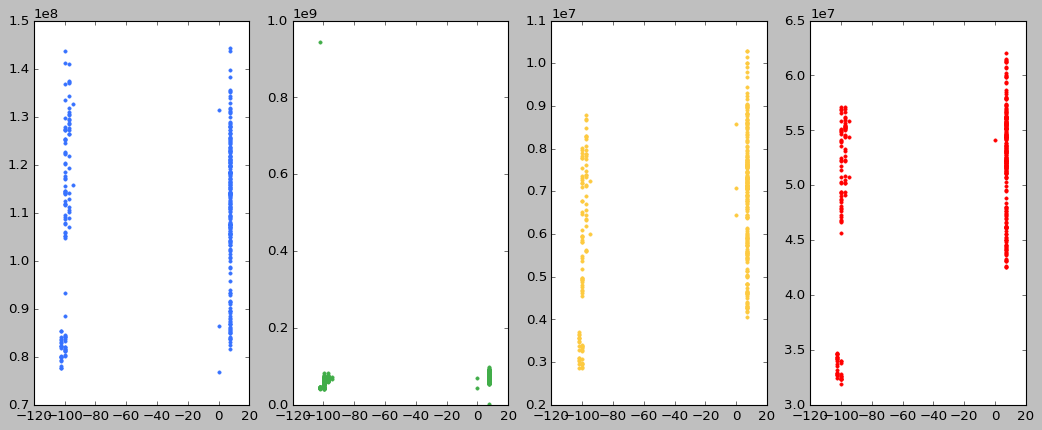

In [47]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(1,4,figsize=(16,6))
axes[0].plot(temps_171,f171,marker='.',color=cs[3],ls='None')
axes[1].plot(temps_195,f195,marker='.',color=cs[2],ls='None')
axes[2].plot(temps_284,f284,marker='.',color=cs[1],ls='None')
axes[3].plot(temps_304,f304,marker='.',color=cs[0],ls='None')
#for ax in axes:
    #ax.set_xlim(-110,-90)
#    ax.set_xlim(0,10)
plt.show()

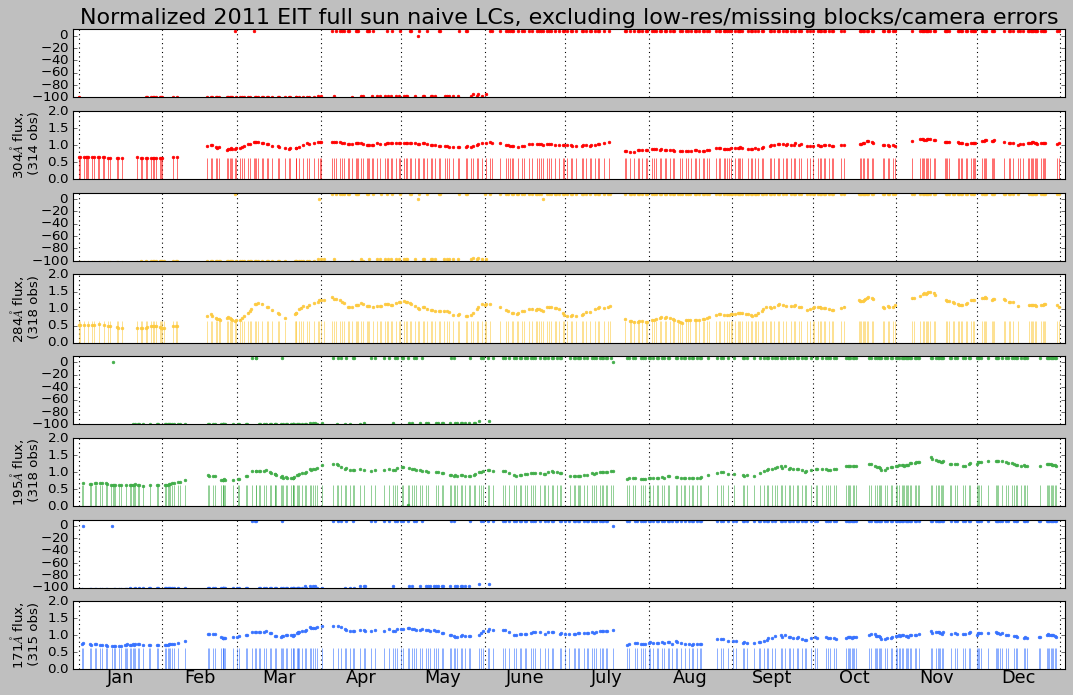

In [48]:
fig, axes = plt.subplots(8,1,figsize=(16,10))

runningdaycount = 0
for i, d in enumerate(dayspermonth):
    for ax in axes:
        ax.axvline(runningdaycount,color='k',ls=':')    
    axes[7].text(runningdaycount + d/2, -0.4, months[i],horizontalalignment='center',fontsize=16)
    runningdaycount = runningdaycount+d
    # leap years
    if year%4 == 0 and i==1:
        runningdaycount = runningdaycount + 1

axes[6].plot(t171-jan1_thisyear, temps_171, ls='None',marker='.',ms=5,c='#3772ff')
axes[4].plot(t195-jan1_thisyear, temps_195, ls='None',marker='.',ms=5,c='#41ad49')
axes[2].plot(t284-jan1_thisyear, temps_284, ls='None',marker='.',ms=5,c='#fdca40')
axes[0].plot(t304-jan1_thisyear, temps_304, ls='None',marker='.',ms=5,c='r')

#axes[4].errorbar(tDark-jan1_thisyear, mfDark/np.median(mfDark), ls='None',marker='.',ms=5,c='k')
axes[7].errorbar(t171-jan1_thisyear, f171/np.median(f171), yerr=unc171/np.median(f171), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#3772ff',ecolor='k')
axes[5].errorbar(t195-jan1_thisyear, f195/np.median(f195), yerr=unc195/np.median(f195), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#41ad49',ecolor='k')
axes[3].errorbar(t284-jan1_thisyear, f284/np.median(f284), yerr=unc284/np.median(f284), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#fdca40',ecolor='k')
axes[1].errorbar(t304-jan1_thisyear, f304/np.median(f304), yerr=unc304/np.median(f304), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='r',ecolor='k')
#ax.set_xlabel('time', fontsize=16) #("BJD-2450083.5 [days since 01/01/{0} 00:00 UTC]".format(year),fontsize=16)


#axes[4].plot(tDark-jan1_thisyear, 0.3*np.ones_like(tDark), ls='None',marker='|',ms=20,mec='k')
axes[7].plot(t171-jan1_thisyear,  0.3*np.ones_like(t171), ls='None',   marker='|',ms=20,mec='#3772ff')
axes[5].plot(t195-jan1_thisyear,  0.3*np.ones_like(t195), ls='None', marker='|',ms=20,mec='#41ad49')
axes[3].plot(t284-jan1_thisyear,  0.3*np.ones_like(t284), ls='None', marker='|',ms=20,mec='#fdca40')
axes[1].plot(t304-jan1_thisyear,  0.3*np.ones_like(t304), ls='None', marker='|',ms=20,mec='r')


#axes[4].set_ylabel("Median dark""\n""frame flux,""\n""({0} obs)".format(len(tDark)))
axes[7].set_ylabel(r"171$\AA$ flux,""\n"" ({0} obs)".format(len(t171)))
axes[5].set_ylabel(r"195$\AA$ flux,""\n"" ({0} obs)".format(len(t195)))
axes[3].set_ylabel(r"284$\AA$ flux,""\n"" ({0} obs)".format(len(t284)))
axes[1].set_ylabel(r"304$\AA$ flux,""\n"" ({0} obs)".format(len(t304)))


for ax in axes:
    ax.set_xticks([])
    ax.set_xlim(-2,runningdaycount+2)
    #ax.axhline(1,ls=":",color='k',zorder=1,lw=0.5)
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    
for ax in [axes[1],axes[3],axes[5],axes[7]]:
    ax.set_ylim(0.,2)

for ax in [axes[0],axes[2],axes[4],axes[6]]:
    ax.set_ylim(-100,10)

    
axes[0].set_title(r'Normalized {0} EIT full sun naive LCs, excluding low-res/missing blocks/camera errors'.format(year),fontsize=20)
plt.show()
#plt.savefig("./EITnaiveLCs_{0}.pdf".format(year), bbox_inches="tight")

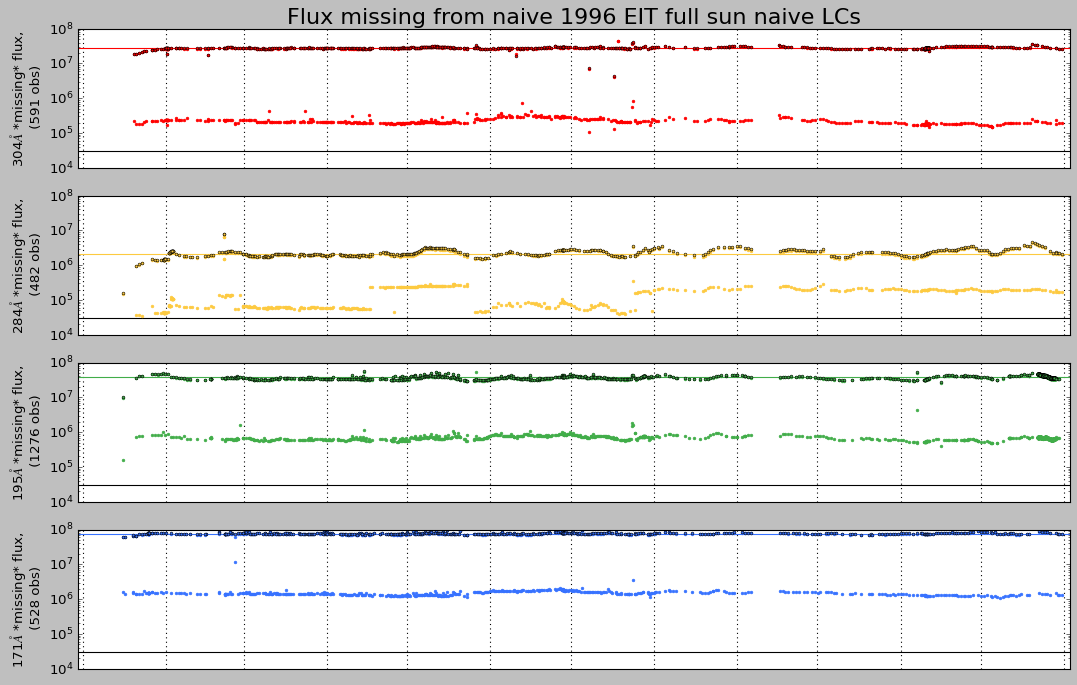

In [12]:
fig, axes = plt.subplots(4,1,figsize=(16,10))

runningdaycount = 0
for i, d in enumerate(dayspermonth):
    for ax in axes:
        ax.axvline(runningdaycount,color='k',ls=':')    
    #axes[3].text(runningdaycount + d/2, -0.4, months[i],horizontalalignment='center',fontsize=16)
    runningdaycount = runningdaycount+d
    # leap years
    if year%4 == 0 and i==1:
        runningdaycount = runningdaycount + 1
    
axes[3].errorbar(t171-jan1_thisyear, m171, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#3772ff',ecolor='k')
axes[2].errorbar(t195-jan1_thisyear, m195, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#41ad49',ecolor='k')
axes[1].errorbar(t284-jan1_thisyear, m284, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#fdca40',ecolor='k')
axes[0].errorbar(t304-jan1_thisyear, m304, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='r',ecolor='k')

axes[3].errorbar(t171-jan1_thisyear, f171, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#3772ff',ecolor='k')
axes[2].errorbar(t195-jan1_thisyear, f195, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#41ad49',ecolor='k')
axes[1].errorbar(t284-jan1_thisyear, f284, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#fdca40',ecolor='k')
axes[0].errorbar(t304-jan1_thisyear, f304, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='r',ecolor='k')

axes[3].errorbar(t171-jan1_thisyear, f171+m171, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#3772ff',markeredgecolor='k')
axes[2].errorbar(t195-jan1_thisyear, f195+m195, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#41ad49',markeredgecolor='k')
axes[1].errorbar(t284-jan1_thisyear, f284+m284, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='#fdca40',markeredgecolor='k')
axes[0].errorbar(t304-jan1_thisyear, f304+m304, ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c='r',markeredgecolor='k')

axes[3].axhline(np.median(f171), ls='-', color='#3772ff')
axes[2].axhline(np.median(f195), ls='-', color='#41ad49')
axes[1].axhline(np.median(f284), ls='-', color='#fdca40')
axes[0].axhline(np.median(f304), ls='-', color='r')

axes[3].axhline(np.median(unc171), ls='-', color='k')
axes[2].axhline(np.median(unc195), ls='-', color='k')
axes[1].axhline(np.median(unc284), ls='-', color='k')
axes[0].axhline(np.median(unc304), ls='-', color='k')

#axes[3].plot(t171-jan1_thisyear,  0.3*np.ones_like(t171), ls='None',   marker='|',ms=20,mec='#3772ff')
#axes[2].plot(t195-jan1_thisyear,  0.3*np.ones_like(t195), ls='None', marker='|',ms=20,mec='#41ad49')
#axes[1].plot(t284-jan1_thisyear,  0.3*np.ones_like(t284), ls='None', marker='|',ms=20,mec='#fdca40')
#axes[0].plot(t304-jan1_thisyear,  0.3*np.ones_like(t304), ls='None', marker='|',ms=20,mec='r')

axes[3].set_ylabel(r"171$\AA$ *missing* flux,""\n"" ({0} obs)".format(len(t171)))
axes[2].set_ylabel(r"195$\AA$ *missing* flux,""\n"" ({0} obs)".format(len(t195)))
axes[1].set_ylabel(r"284$\AA$ *missing* flux,""\n"" ({0} obs)".format(len(t284)))
axes[0].set_ylabel(r"304$\AA$ *missing* flux,""\n"" ({0} obs)".format(len(t304)))


for ax in axes:
    ax.set_xticks([])
    ax.set_xlim(-2,runningdaycount+2)
    #ax.axhline(1,ls=":",color='k',zorder=1,lw=0.5)
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_yscale("log")
    ax.set_ylim(1.e4,1.e8)

axes[0].set_title(r'Flux missing from naive {0} EIT full sun naive LCs'.format(year),fontsize=20)
#plt.show()
plt.savefig("./EITnaiveLCs_missingflux_{0}.pdf".format(year), bbox_inches="tight")

In [19]:
print("summed 171 flux is {0}".format(np.median(f171)))
print("summed 195 flux is {0}".format(np.median(f195)))
print("summed 284 flux is {0}".format(np.median(f284)))
print("summed 304 flux is {0}".format(np.median(f304)))

summed 171 flux is 75735088.0
summed 195 flux is 37606040.0
summed 284 flux is 2075791.0
summed 304 flux is 27552604.0


In [20]:
print("171 unc is {0}".format(np.median(unc171)))
print("195 unc is {0}".format(np.median(unc195)))
print("284 unc is {0}".format(np.median(unc284)))
print("304 unc is {0}".format(np.median(unc304)))

171 unc is 31130.72265625
195 unc is 30512.17578125
284 unc is 29924.279296875
304 unc is 30346.982421875


In [22]:
print("excluded 171 flux is {0}".format(np.median(m171)))
print("excluded 195 flux is {0}".format(np.median(m195)))
print("excluded 284 flux is {0}".format(np.median(m284)))
print("excluded 304 flux is {0}".format(np.median(m304)))

excluded 171 flux is 1445923.75
excluded 195 flux is 678098.75
excluded 284 flux is 109562.953125
excluded 304 flux is 207169.6875


In [21]:
print("171 SNR is {0}".format(np.median(f171)/np.median(unc171)))
print("195 SNR is {0}".format(np.median(f195)/np.median(unc195)))
print("284 SNR is {0}".format(np.median(f284)/np.median(unc284)))
print("304 SNR is {0}".format(np.median(f304)/np.median(unc304)))

171 SNR is 2432.80859375
195 SNR is 1232.492919921875
284 SNR is 69.36811828613281
304 SNR is 907.9190673828125


In [23]:
print("171 exc/summed is {0}".format(np.median(m171)/np.median(f171)))
print("195 exc/summed is {0}".format(np.median(m195)/np.median(f195)))
print("284 exc/summed is {0}".format(np.median(m284)/np.median(f284)))
print("304 exc/summed is {0}".format(np.median(m304)/np.median(f304)))

171 exc/summed is 0.019091861322522163
195 exc/summed is 0.018031645566225052
284 exc/summed is 0.052781302481889725
304 exc/summed is 0.007519060280174017


In [15]:
print("171 median is {0}".format(np.sqrt(np.median(f171))))
print("195 median is {0}".format(np.sqrt(np.median(f195))))
print("284 median is {0}".format(np.sqrt(np.median(f284))))
print("304 median is {0}".format(np.sqrt(np.median(f304))))

171 median is 8702.5908203125
195 median is 6132.37646484375
284 median is 1440.7606201171875
304 median is 5249.0576171875


In [22]:
results = np.genfromtxt("./EIT/EITresults/EIT_LC.txt")
pinholes = np.genfromtxt("./EIT/EITresults/EIT_pinholes.txt")

results = results[np.argsort(results[:,0])]
pinholes = pinholes[np.argsort(pinholes[:,0])]

In [23]:
ps = pinholes[:,2]
ts = results[:,0]
ws = results[:,2]
fs = results[:,3] * (results[:,1]/np.median(results[:,1]))
us = results[:,4] * (results[:,1]/np.median(results[:,1]))
m171 = (ws == 171.) & (ps == 0.)
m195 = (ws == 195.) & (ps == 0.)
m284 = (ws == 284.) & (ps == 0.)
m304 = (ws == 304.) & (ps == 0.)
wmasks = [m304,m284,m195,m171]

In [24]:
print(np.shape(fs[m171]))
print(np.shape(fs[m195]))
print(np.shape(fs[m284]))
print(np.shape(fs[m304]))

(22303,)
(22260,)
(15135,)
(21761,)


0
(21761,)
(21761,)
1
(15135,)
(15135,)
2
(22260,)
(22260,)
3
(22303,)
(22303,)


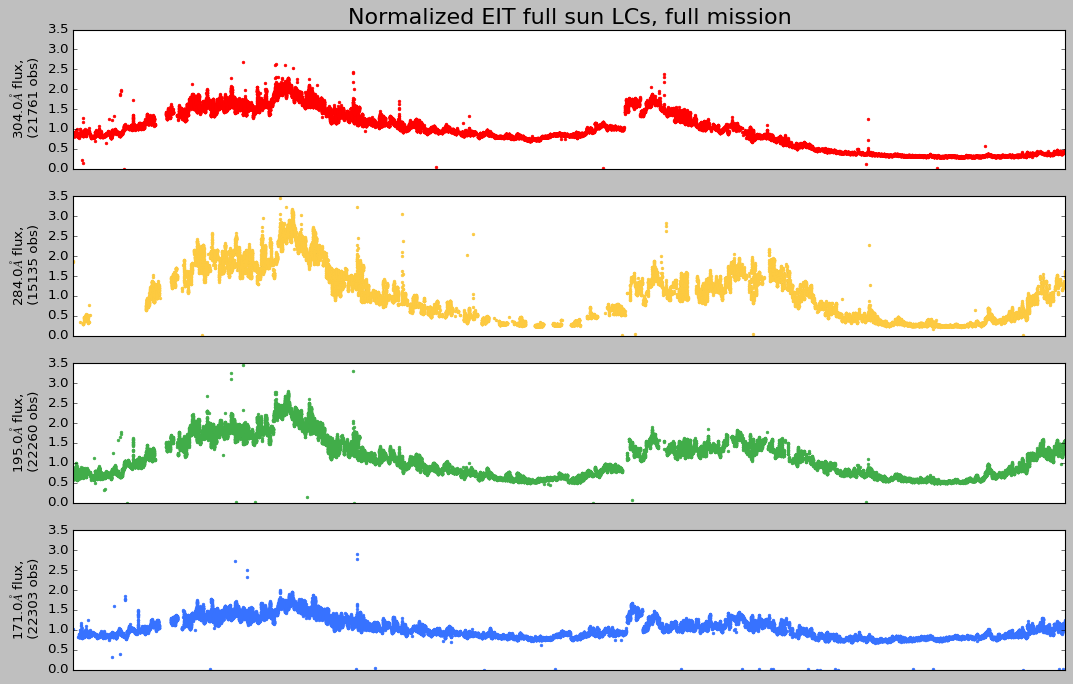

In [26]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,10))
"""
runningdaycount = 0
for i, d in enumerate(dayspermonth):
    for ax in axes:
        ax.axvline(runningdaycount,color='k',ls=':')    
    axes[3].text(runningdaycount + d/2, -0.4, months[i],horizontalalignment='center',fontsize=16)
    runningdaycount = runningdaycount+d
    # leap years
    if year%4 == 0 and i==1:
        runningdaycount = runningdaycount + 1
"""
for i, ax in enumerate(axes):
    print(i)
    wmask = wmasks[i]

    plotcolor = cs[i]
    axes[i].errorbar(ts[wmask], fs[wmask]/np.median(fs[wmask][~np.isnan(fs[wmask])]), yerr=us[wmask]/np.median(fs[wmask][~np.isnan(fs[wmask])]), ls='None', elinewidth=1, capsize=0, marker='.',ms=5,c=plotcolor,ecolor='k')
    #axes[i].plot(ts[wmask], 0.3*np.ones_like(ts[wmask]), marker='|',ms=20,mec=plotcolor,ls='None')
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))

for ax in axes:
    ax.set_xticks([])
    #ax.set_xlim(-2,runningdaycount+2)

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,3.5)

    
axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
#plt.show()
plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")